# Project 4: Advanced Lane Lines
### By Steven Eisinger
---

## Pipeline description
1) read in image/video data

2) calibrate camera

3) undistort image

4) change image perspective

5) find lanes

6) draw lanes onto original image

---

## Imports

In [1]:
# Udacity Self Driving Car Nanodegree Project 4
__title__ = 'SDC Project 4: Advanced Lane Lines'
__author__ = 'Steven Eisinger'

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Find Chessboard Points

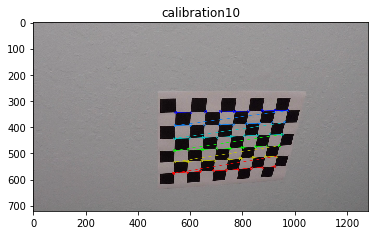

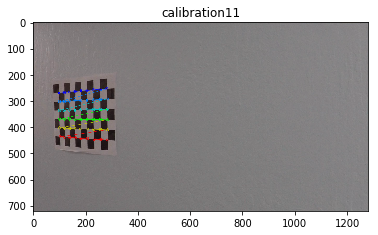

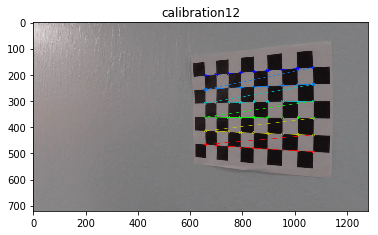

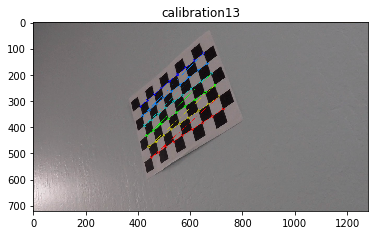

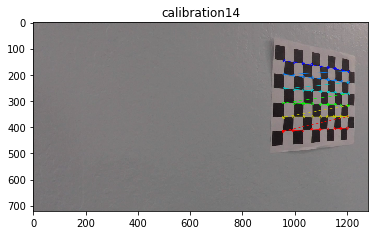

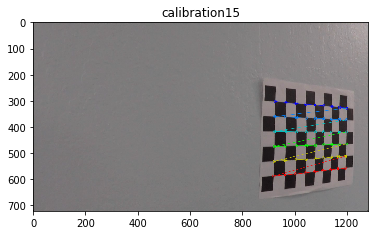

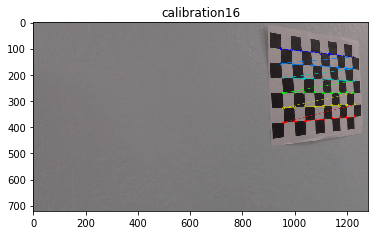

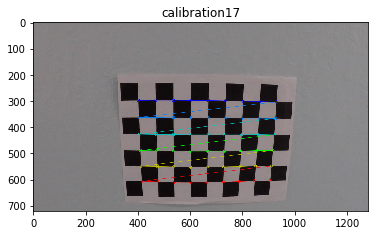

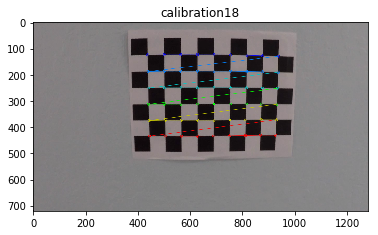

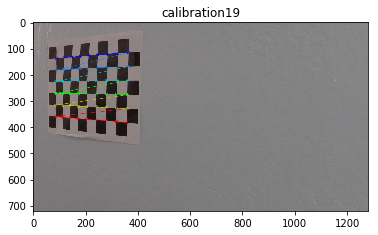

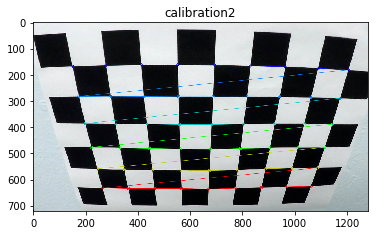

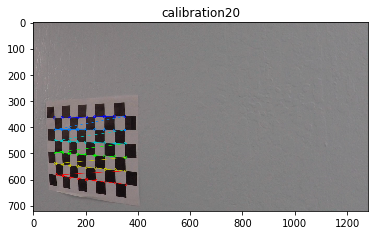

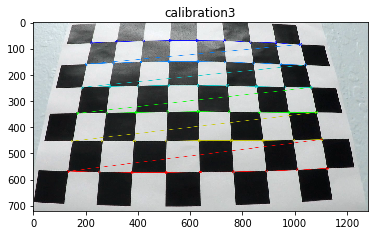

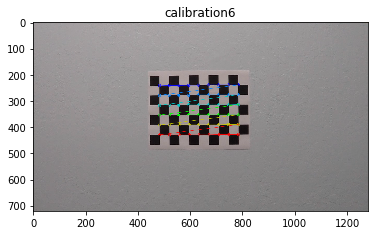

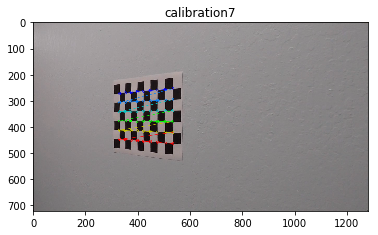

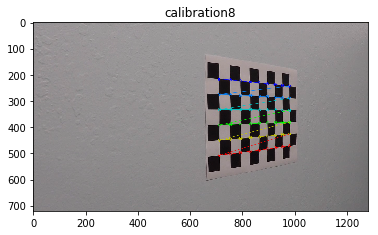

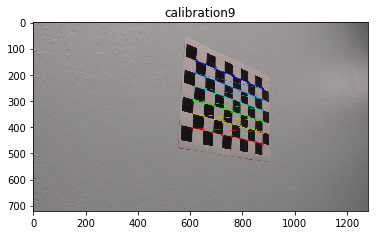

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
chess_y = 6
chess_x = 9
objp = np.zeros((chess_y*chess_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_x, 0:chess_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_x,chess_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chess_x,chess_y), corners2, ret)
        write_name = 'output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        plt.imshow(img,cmap='gray')
        plt.title(fname.split('/')[-1].split('.')[0])
        plt.show()

## Camera Calibration and Distortion Correction

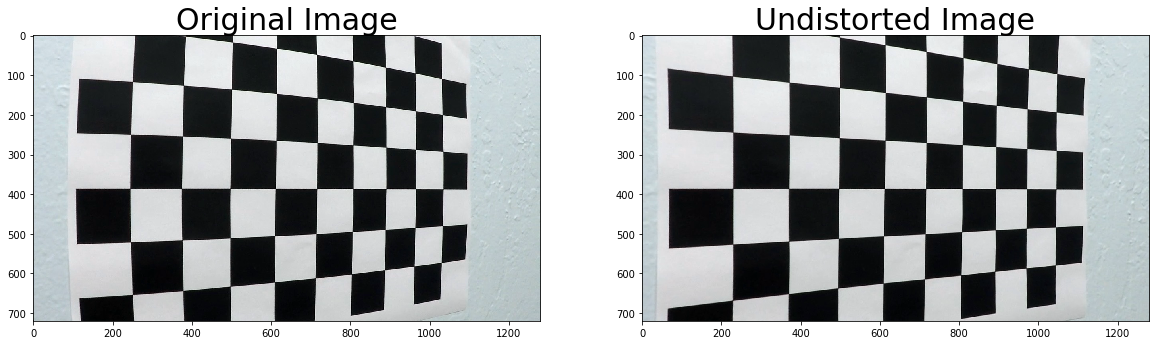

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist_calibration5.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Color and Gradient Threshold

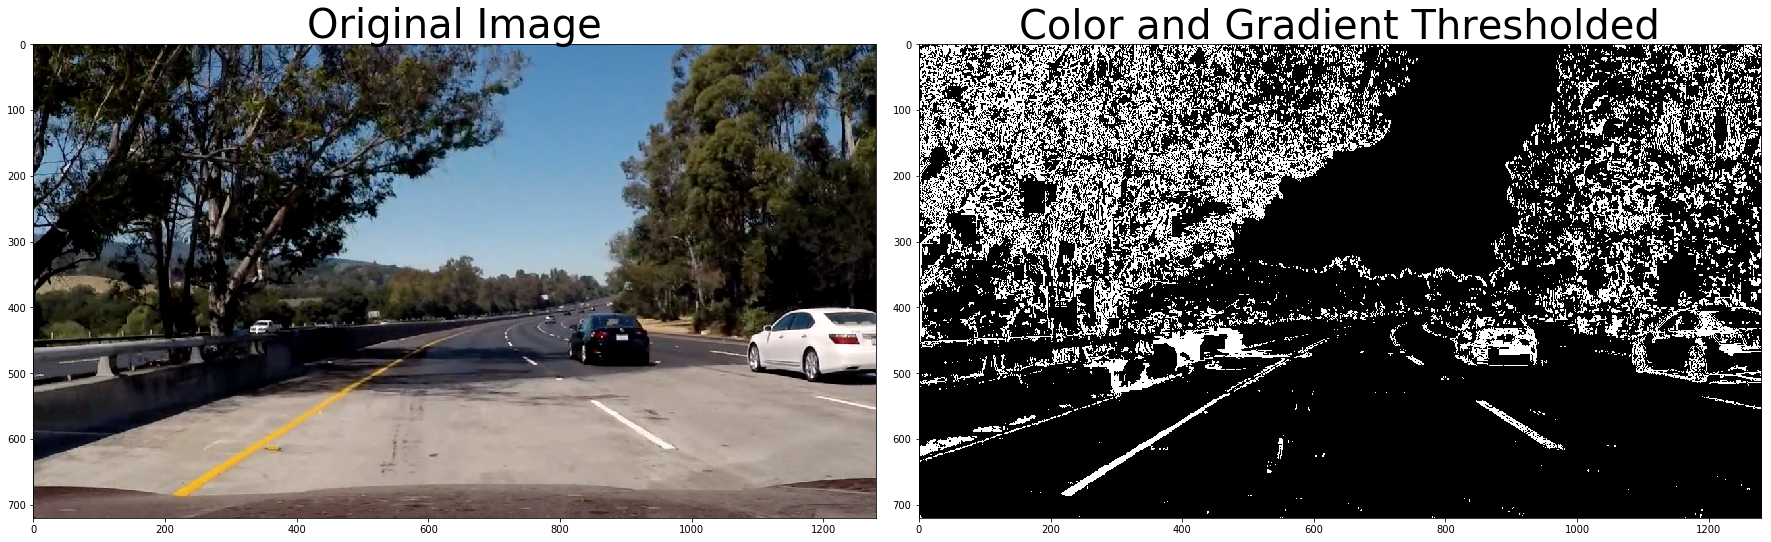

In [100]:
# Thresholding pipeline
def thresh_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Make image binary (Remove to see colors)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = thresh_pipeline(img) # TODO: Experiment with different values
cv2.imwrite('output_images/color_grad_thresh.jpg',result*255)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Color and Gradient Thresholded', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

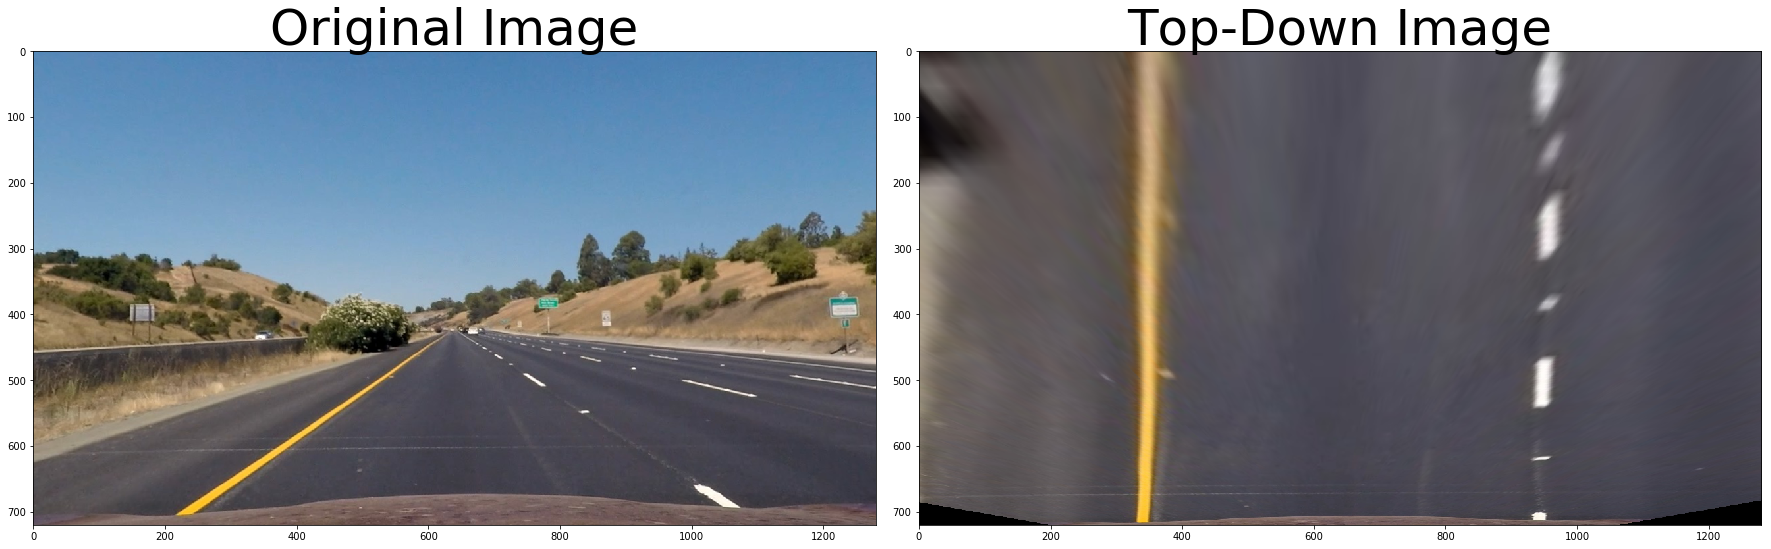

In [166]:
def top_down_perspective(img, M):
    # Use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
    return warped

dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

# Define src and dst based on straight line images
src = np.float32([(177, 720), (1132, 720), (593, 449), (683, 449)]) # TODO: Refine these values
dst = np.float32([(320, 720), (960, 720), (320, 0), (960, 0)])
# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the M, Minv result for later use
M_pickle = {}
M_pickle["M"] = M
M_pickle["Minv"] = Minv
pickle.dump( M_pickle, open( "M_pickle.p", "wb" ) )

top_down = top_down_perspective(img, M)

cv2.imwrite('output_images/perspective_transform.jpg', cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Top-Down Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Lanes and Fit Polynomial

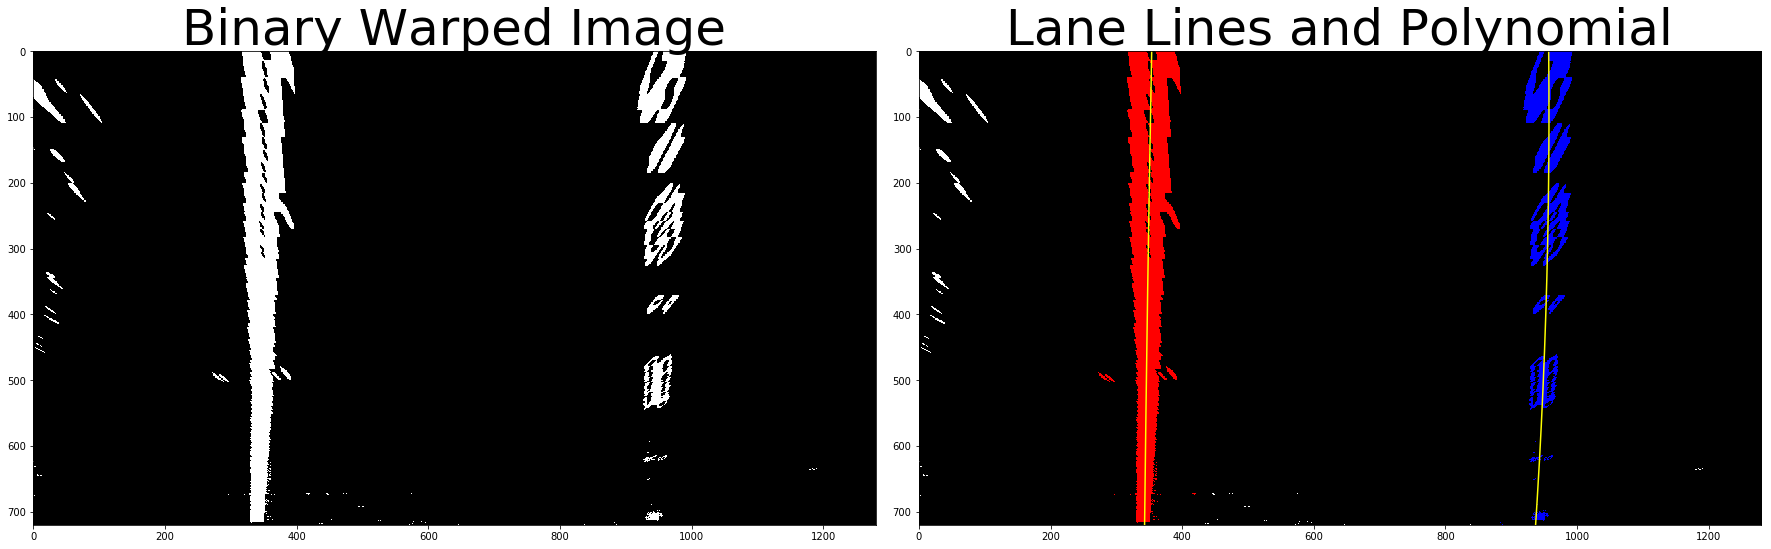

In [157]:
def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fitx, right_fitx

# Load image and undistort
dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
thresh = thresh_pipeline(img)
top_down = top_down_perspective(thresh, M)

out_img, ploty, left_fit, right_fit = find_lanes(top_down)

cv2.imwrite('output_images/find_lane_lines.jpg', out_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down, cmap='gray')
ax1.set_title('Binary Warped Image', fontsize=50)
ax2.imshow(out_img)
ax2.plot(left_fit, ploty, color='yellow')
ax2.plot(right_fit, ploty, color='yellow')
ax2.set_title('Lane Lines and Polynomial', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Radius of Curvature

In [153]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Radius of curvature (px):', left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius of curvature (m):', left_curverad, 'm', right_curverad, 'm')

Radius of curvature (px): 1.86408464176e+14 1.36403905626e+15
Radius of curvature (m): 31889.5677584 m 3156.11153643 m


## Full Lane Finding Pipeline (Checkpoint)

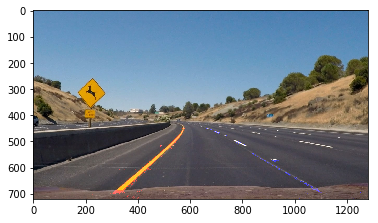

In [179]:
# TODO: Draw green space in between lane lines using radius of curvature then superimpose everything onto original
# TODO: Fill in line space in the find_lanes function
def draw_lanes(img, mtx, dist, M, Minv):
    # Calibrate camera
    calibrated = cv2.undistort(img, mtx, dist, None, mtx)
    # Threshold image
    thresholded = thresh_pipeline(calibrated)
    # Get top-down perspective
    warped = top_down_perspective(thresholded, M)
    # Find lane lines
    lanes, ploty, left_fit, right_fit = find_lanes(warped)
    # Remove white pixels
    lanes[np.where((lanes == [255,255,255]).all(axis = 2))] = [0,0,0]
    # Unwarp image
    unwarped = top_down_perspective(lanes, Minv)
    
    img = cv2.addWeighted(img, 1, unwarped, 1, 0)
    return img

dist_pickle = pickle.load(open("camera_cal_pickle.p", "rb"))
M_pickle = pickle.load(open("M_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = M_pickle["M"]
Minv = M_pickle["Minv"]
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output = draw_lanes(img, mtx, dist, M, Minv)
plt.imshow(output)

## Video Pipeline

In [181]:
from moviepy.editor import VideoFileClip

def process_image(img):
    return draw_lanes(img, mtx, dist, M, Minv)
    
movie_output = 'draw_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(movie_output, audio=False)

[MoviePy] >>>> Building video draw_lines.mp4
[MoviePy] Writing video draw_lines.mp4


100%|█████████▉| 1260/1261 [04:51<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: draw_lines.mp4 

CPU times: user 5min 6s, sys: 6.07 s, total: 5min 12s
Wall time: 4min 53s
